## Setup & Import Required Libraries

In [1]:
# ============================================
# Phase 1: Setup & Library Imports
# ============================================

# Mount Google Drive if needed (Optional)
from google.colab import drive
drive.mount('/content/drive')

# Import Python libraries
import os
import random
import shutil
from pathlib import Path
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("Environment ready")


Mounted at /content/drive
Environment ready


## Dataset Preparation

In [2]:
# ============================================
# Phase 2: Dataset Preparation (Train/Val/Test)
# ============================================

from pathlib import Path
import shutil, random
from PIL import Image

# Use Google Drive as source
SRC = Path("/content/drive/MyDrive/DL_Project")  # <- your Drive folder
TARGET = Path("/content/brain-tumor-yolo")       # organized output
CLASSES = ["glioma", "meningioma", "pituitary", "notumor"]

# (Optional) Clean old TARGET to avoid duplicates across re-runs
if TARGET.exists():
    shutil.rmtree(TARGET)

# Create train, val, test folders
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        (TARGET / split / cls).mkdir(parents=True, exist_ok=True)

# Helper to check valid image files
def is_valid_image(p: Path):
    try:
        with Image.open(p) as im:
            im.verify()
        return True
    except Exception:
        return False

# Split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

# Split and copy files from Drive
for cls in CLASSES:
    src_dir = SRC / cls
    if not src_dir.exists():
        raise FileNotFoundError(f"Missing folder in Drive: {src_dir}")

    files = [p for p in src_dir.iterdir() if p.is_file() and is_valid_image(p)]
    random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]

    for p in train_files:
        shutil.copy2(p, TARGET / "train" / cls / p.name)
    for p in val_files:
        shutil.copy2(p, TARGET / "val" / cls / p.name)
    for p in test_files:
        shutil.copy2(p, TARGET / "test" / cls / p.name)

print("Dataset organized into train / val / test")
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        count = len(list((TARGET / split / cls).glob("*")))
        print(f"{split}/{cls}: {count} images")

Dataset organized into train / val / test
train/glioma: 1134 images
train/meningioma: 1151 images
train/pituitary: 1229 images
train/notumor: 1400 images
val/glioma: 324 images
val/meningioma: 329 images
val/pituitary: 351 images
val/notumor: 400 images
test/glioma: 163 images
test/meningioma: 165 images
test/pituitary: 177 images
test/notumor: 200 images


## Data Visualization (Samples)

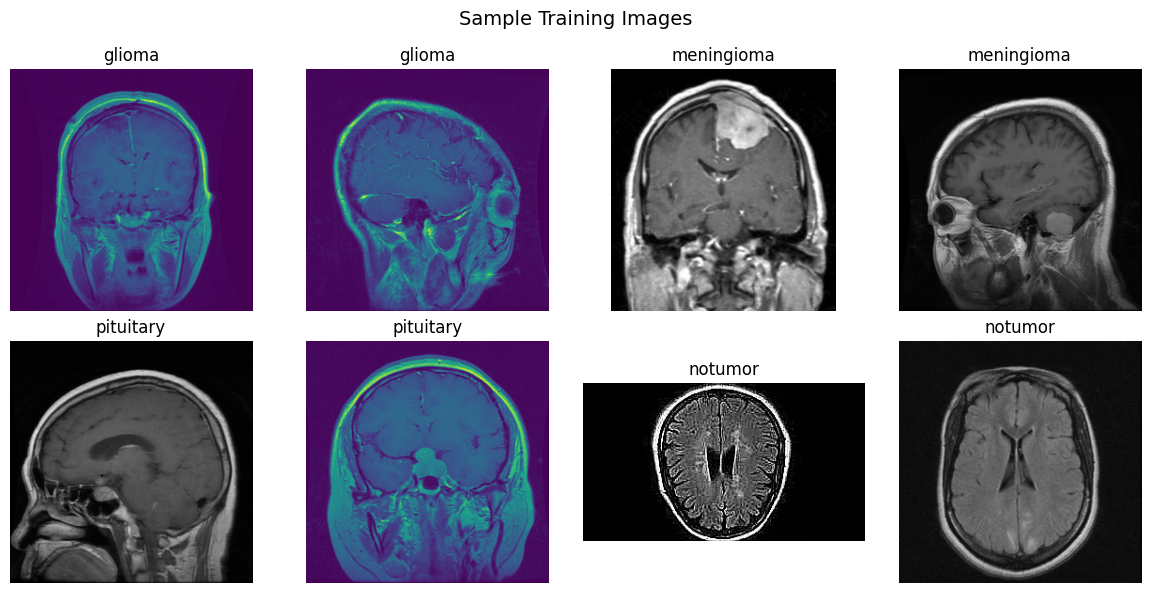

In [3]:
# ============================================
# Phase 3: Quick Visualization of Images
# ============================================

sample_paths = []
for cls in CLASSES:
    sample_paths += list((TARGET/"train"/cls).glob("*"))[:2]

plt.figure(figsize=(12,6))
for i, img_path in enumerate(sample_paths):
    img = Image.open(img_path)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(CLASSES[i//2])
plt.suptitle("Sample Training Images", fontsize=14)
plt.tight_layout()
plt.show()

## Data Generators (Preprocessing)

In [4]:
# ============================================
# Phase 4: Data Generators & Preprocessing
# ============================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentation for training, only rescale for validation/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TARGET/"train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    TARGET/"val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    TARGET/"test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Data generators ready")


Found 4914 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.
Found 705 images belonging to 4 classes.
Data generators ready


## Build Custom CNN

In [5]:
# ============================================
# Phase 5: Build Custom CNN Model from Scratch
# ============================================
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block_no_l2(x, filters, k=3):
    x = Conv2D(filters, (k, k), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

inp = Input(shape=(224, 224, 3))

x = conv_block_no_l2(inp, 32);  x = conv_block_no_l2(x, 32);  x = MaxPooling2D()(x)
x = conv_block_no_l2(x,  64);   x = conv_block_no_l2(x, 64);  x = MaxPooling2D()(x)
x = conv_block_no_l2(x, 128);   x = conv_block_no_l2(x,128);  x = MaxPooling2D()(x)
x = conv_block_no_l2(x, 256);   x = conv_block_no_l2(x,256);  x = MaxPooling2D()(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.3)(x)
out = Dense(4, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile(
    optimizer=Adam(learning_rate=1e-3),  # start a bit higher than TL
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             

 Total params: 1,208,548 (4.61 MB)

 Trainable params: 1,206,628 (4.60 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Callbacks and Training


In [6]:
# ============================================
# Phase 6: Training Setup & Callbacks
# ============================================

EPOCHS = 40
BASE_LR = 3e-4

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_cnn_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("Training completed")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.5628 - loss: 1.0580
Epoch 1: val_accuracy improved from -inf to 0.28490, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 121s 619ms/step - accuracy: 0.5632 - loss: 1.0570 - val_accuracy: 0.2849 - val_loss: 5.3039 - learning_rate: 0.0010
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7036 - loss: 0.7425
Epoch 2: val_accuracy improved from 0.28490 to 0.45726, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 77s 500ms/step - accuracy: 0.7037 - loss: 0.7423 - val_accuracy: 0.4573 - val_loss: 1.3126 - learning_rate: 0.0010
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7400 - loss: 0.6600
Epoch 3: val_accuracy did not improve from 0.45726
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 477ms/step - accuracy: 0.7400 - loss: 0.6599 - val_accuracy: 0.4494 - val_loss: 1.3826 - learning_rate: 0.0010
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7697 - loss: 0.5848
Epoch 4: val_accuracy did not improve from 0.45726
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 477ms/step - accuracy: 0.7697 - loss: 0.5848 - val_accuracy: 0.3219 - val_loss: 7.5155 - learning_rate: 0.0010
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8015 - loss: 0.5209
Epoch 5: val_accuracy improved from 0.45726 to 0.68091, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 472ms/step - accuracy: 0.8016 - loss: 0.5209 - val_accuracy: 0.6809 - val_loss: 1.1566 - learning_rate: 0.0010
Epoch 6/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8150 - loss: 0.4975
Epoch 6: val_accuracy did not improve from 0.68091
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 483ms/step - accuracy: 0.8150 - loss: 0.4974 - val_accuracy: 0.4423 - val_loss: 3.2475 - learning_rate: 0.0010
Epoch 7/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8274 - loss: 0.4603
Epoch 7: val_accuracy did not improve from 0.68091
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 473ms/step - accuracy: 0.8274 - loss: 0.4602 - val_accuracy: 0.4744 - val_loss: 2.5834 - learning_rate: 0.0010
Epoch 8/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8399 - loss: 0.4301
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_accuracy did not improve from 0.68091
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 478ms/step - accuracy: 0.8399 - loss: 0.4

154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 481ms/step - accuracy: 0.8570 - loss: 0.3885 - val_accuracy: 0.7443 - val_loss: 0.7580 - learning_rate: 5.0000e-04
Epoch 10/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8626 - loss: 0.3470
Epoch 10: val_accuracy improved from 0.74430 to 0.78704, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 474ms/step - accuracy: 0.8626 - loss: 0.3470 - val_accuracy: 0.7870 - val_loss: 0.5440 - learning_rate: 5.0000e-04
Epoch 11/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8777 - loss: 0.3241
Epoch 11: val_accuracy did not improve from 0.78704
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy: 0.8777 - loss: 0.3241 - val_accuracy: 0.6581 - val_loss: 1.1742 - learning_rate: 5.0000e-04
Epoch 12/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8757 - loss: 0.3319
Epoch 12: val_accuracy did not improve from 0.78704
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 488ms/step - accuracy: 0.8757 - loss: 0.3319 - val_accuracy: 0.6752 - val_loss: 1.3252 - learning_rate: 5.0000e-04
Epoch 13/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8817 - loss: 0.3155
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: val_accuracy did not improve from 0.78704
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 470ms/step - accuracy:

154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 489ms/step - accuracy: 0.8816 - loss: 0.2911 - val_accuracy: 0.8362 - val_loss: 0.4593 - learning_rate: 2.5000e-04
Epoch 15/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9016 - loss: 0.2706
Epoch 15: val_accuracy improved from 0.83618 to 0.87749, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 470ms/step - accuracy: 0.9016 - loss: 0.2706 - val_accuracy: 0.8775 - val_loss: 0.3357 - learning_rate: 2.5000e-04
Epoch 16/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8883 - loss: 0.2947
Epoch 16: val_accuracy did not improve from 0.87749
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 486ms/step - accuracy: 0.8883 - loss: 0.2946 - val_accuracy: 0.8768 - val_loss: 0.3777 - learning_rate: 2.5000e-04
Epoch 17/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9030 - loss: 0.2590
Epoch 17: val_accuracy did not improve from 0.87749
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy: 0.9030 - loss: 0.2590 - val_accuracy: 0.8718 - val_loss: 0.3799 - learning_rate: 2.5000e-04
Epoch 18/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9058 - loss: 0.2467
Epoch 18: val_accuracy did not improve from 0.87749
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 482ms/step - accuracy: 0.9058 - loss: 0.2467 - val_accuracy: 0.8640 - val_loss: 0.3298 - learning_ra

154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 474ms/step - accuracy: 0.9087 - loss: 0.2474 - val_accuracy: 0.9088 - val_loss: 0.2699 - learning_rate: 2.5000e-04
Epoch 20/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9084 - loss: 0.2506
Epoch 20: val_accuracy did not improve from 0.90883
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 477ms/step - accuracy: 0.9084 - loss: 0.2506 - val_accuracy: 0.8946 - val_loss: 0.2852 - learning_rate: 2.5000e-04
Epoch 21/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9133 - loss: 0.2291
Epoch 21: val_accuracy did not improve from 0.90883
154/154 ━━━━━━━━━━━━━━━━━━━━ 76s 489ms/step - accuracy: 0.9134 - loss: 0.2291 - val_accuracy: 0.8027 - val_loss: 0.8526 - learning_rate: 2.5000e-04
Epoch 22/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9129 - loss: 0.2251
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: val_accuracy did not improve from 0.90883
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 487ms/step - accuracy:

154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 474ms/step - accuracy: 0.9317 - loss: 0.1834 - val_accuracy: 0.9281 - val_loss: 0.1841 - learning_rate: 1.2500e-04
Epoch 24/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9261 - loss: 0.2045
Epoch 24: val_accuracy improved from 0.92806 to 0.92949, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 478ms/step - accuracy: 0.9261 - loss: 0.2044 - val_accuracy: 0.9295 - val_loss: 0.1958 - learning_rate: 1.2500e-04
Epoch 25/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9345 - loss: 0.1757
Epoch 25: val_accuracy did not improve from 0.92949
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 476ms/step - accuracy: 0.9346 - loss: 0.1757 - val_accuracy: 0.9209 - val_loss: 0.2276 - learning_rate: 1.2500e-04
Epoch 26/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9315 - loss: 0.1800
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 26: val_accuracy did not improve from 0.92949
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 478ms/step - accuracy: 0.9315 - loss: 0.1800 - val_accuracy: 0.8917 - val_loss: 0.3418 - learning_rate: 1.2500e-04
Epoch 27/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9346 - loss: 0.1755
Epoch 27: val_accuracy improved from 0.92949 to 0.93447, saving model to best_cnn_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 474ms/step - accuracy: 0.9346 - loss: 0.1754 - val_accuracy: 0.9345 - val_loss: 0.1761 - learning_rate: 6.2500e-05
Epoch 28/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9325 - loss: 0.1756
Epoch 28: val_accuracy did not improve from 0.93447
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 470ms/step - accuracy: 0.9325 - loss: 0.1755 - val_accuracy: 0.9252 - val_loss: 0.2101 - learning_rate: 6.2500e-05
Epoch 29/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9495 - loss: 0.1540
Epoch 29: val_accuracy did not improve from 0.93447
154/154 ━━━━━━━━━━━━━━━━━━━━ 74s 482ms/step - accuracy: 0.9495 - loss: 0.1540 - val_accuracy: 0.9088 - val_loss: 0.2832 - learning_rate: 6.2500e-05
Epoch 30/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9436 - loss: 0.1584
Epoch 30: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 30: val_accuracy did not improve from 0.93447
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 466ms/step - accuracy:

154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 468ms/step - accuracy: 0.9525 - loss: 0.1436 - val_accuracy: 0.9444 - val_loss: 0.1729 - learning_rate: 1.5625e-05
Epoch 36/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9506 - loss: 0.1355
Epoch 36: val_accuracy did not improve from 0.94444
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy: 0.9506 - loss: 0.1355 - val_accuracy: 0.9437 - val_loss: 0.1949 - learning_rate: 1.5625e-05
Epoch 37/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9486 - loss: 0.1443
Epoch 37: val_accuracy did not improve from 0.94444
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 470ms/step - accuracy: 0.9486 - loss: 0.1443 - val_accuracy: 0.9430 - val_loss: 0.1945 - learning_rate: 1.5625e-05
Epoch 38/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9515 - loss: 0.1350
Epoch 38: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 38: val_accuracy did not improve from 0.94444
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy:

## Training Visualization (Accuracy & Loss Curves)

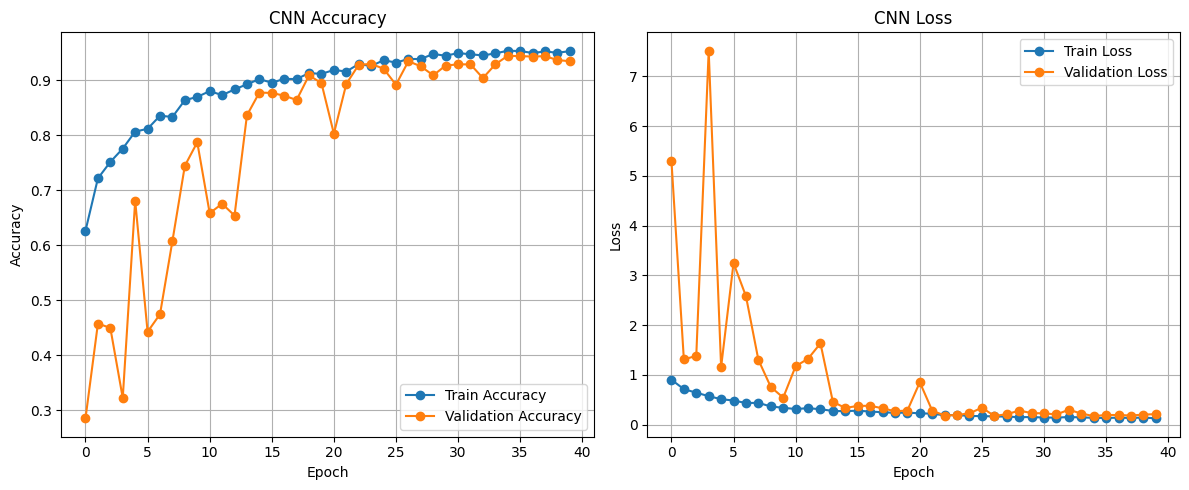

In [7]:
# ============================================
# Phase 7: Training Visualization
# ============================================

plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Evaluation

In [8]:
# ============================================
# Phase 8: Evaluate Model on Test Data
# ============================================

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9276 - loss: 0.1837
Test Accuracy: 94.61%
Test Loss: 0.1443


## Confusion Matrix & Classification Report

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


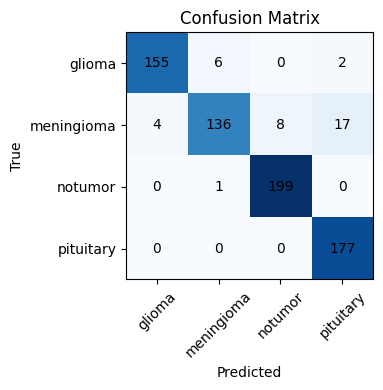

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9748    0.9509    0.9627       163
  meningioma     0.9510    0.8242    0.8831       165
     notumor     0.9614    0.9950    0.9779       200
   pituitary     0.9031    1.0000    0.9491       177

    accuracy                         0.9461       705
   macro avg     0.9476    0.9425    0.9432       705
weighted avg     0.9474    0.9461    0.9450       705



In [9]:
# ============================================
# Phase 9: Confusion Matrix & Classification Report
# ============================================

# Predict on test data
y_pred_probs = model.predict(test_gen)              # shape (N, 4)
y_pred = np.argmax(y_pred_probs, axis=1)           # predicted class indices
y_true = test_gen.classes                           # true class indices
class_labels = [k for k, v in sorted(test_gen.class_indices.items(), key=lambda kv: kv[1])]



# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))
